# The Battle of the Neighborhoods - Week 2

### Introduction & Business Problem :
### Problem Background:

The City of New York is the center of culture, finance, and technology of the world. Thanks to English, the most spoken language, and the potential of its business, many comppanies want to open their business there. Nowadays, New York City is home to more than 8 million people. The city is continuously growing with the growing immigrants and tourists into the United States. 


### Business Problem

- A client wants to open a Japanese restaurant in NYC
- The client is worring about high competion in NYC
- Before opening his restraunt, he needs recommendation where he should open his restaurant
- The recommendation should be data visualized with data analysis

### Target Audience

People in USA are suffered from obesity and unhealty food habit. The needs of Japanese foods as healthy cusine have been rapidly increasing recently. Although there are restaurants like Chinese, French, Indian, and Italian, Japanese restaurants differ from them. Opening Japanese restaurants aim at attracting people who want to reduce their weights with diet and those who don't like meat. Fresh fish and vegetables are very attractive for many American.

### Data

#### To solve the problem, we need the following data:

- New York City data containing neighborhoods and boroughs
- Latitude and longitude to cordinate their neighborhoods. These are required to plot map and venue data
- Venue data related with restaurants. It tells us potential competitors and synagy effects.
- Review of Japanese restaurant in NYC

#### Data Souce:

New York City data containing the neighborhoods and boroughs will be obtained from the following open data,

https://cocl.us/new_york_dataset


The method using for data analysis is web scrapping with Foursquare API and map visualization (Folium). This enables us to explore data and make data analysis.

In [1]:
pip install geopy

     |████████████████████████████████| 112kB 46.2MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    attrs-20.3.0               |     pyhd3deb0d_0          41 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    entrypoints-0.3            |  pyhd8ed1ab_1003           8 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    jsonschema-3.2.0           |     pyhd8ed1ab_3          45 KB  conda-forge
    pandas-1.1.5               |   py36h284efc9_0        11.3 MB  conda-

In [36]:
# Define Foursquare Credentials and Version
CLIENT_ID = ''# Foursquare ID, note there is a daily call quota limit 
CLIENT_SECRET ='' # Foursquare Secret, note there is a daily call quota it
VERSION = '20180604' # Foursquare API version


In [37]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [38]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [39]:
ny_data.shape

(306, 4)

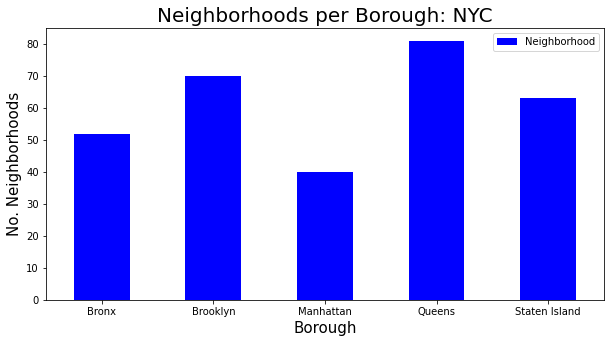

In [63]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [41]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

In [42]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
21,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
22,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
23,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
24,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
39,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


In [43]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '6092b51183ad9968fab9aa94'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
60,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL,57,8.8,10
61,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago,160,8.6,26
62,Manhattan,Flatiron,4a5d064bf964a52010bd1fe3,15 East,269,8.1,136
63,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant,11,7.4,5
64,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou,12,7.8,1


In [44]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [45]:
japanese_rest_stats_ny.shape

(65, 7)

In [46]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       65 non-null     object 
 1   Neighborhood  65 non-null     object 
 2   ID            65 non-null     object 
 3   Name          65 non-null     object 
 4   Likes         65 non-null     object 
 5   Rating        65 non-null     float64
 6   Tips          65 non-null     object 
dtypes: float64(1), object(6)
memory usage: 3.7+ KB


In [47]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       65 non-null     object 
 1   Neighborhood  65 non-null     object 
 2   ID            65 non-null     object 
 3   Name          65 non-null     object 
 4   Likes         65 non-null     float64
 5   Rating        65 non-null     float64
 6   Tips          65 non-null     float64
dtypes: float64(3), object(4)
memory usage: 3.7+ KB


In [48]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,65.000000,65.000000,65.000000
mean,163.738462,8.029231,49.384615
std,259.835481,1.274721,74.000568
min,0.000000,0.000000,0.000000
25%,15.000000,7.600000,6.000000
50%,49.000000,8.200000,15.000000
75%,185.000000,8.700000,63.000000
max,1221.000000,9.300000,352.000000


In [49]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              4f7b61f6e4b07aaa5d524842
Name                 OOTOYA 大戸屋 (OOTOYA)
Likes                               1221
Rating                               9.1
Tips                                 274
Name: 58, dtype: object

In [50]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              5b3805910dd31f002409405a
Name                          Suki Curry
Likes                                 57
Rating                               9.3
Tips                                  15
Name: 28, dtype: object

In [51]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                791
Rating                               8.7
Tips                                 352
Name: 25, dtype: object

In [52]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
11,East Village,9.250000
21,Hunters Point,9.133333
33,North Side,9.000000
9,Cobble Hill,9.000000
10,Downtown,8.900000
34,Park Slope,8.900000
39,Soho,8.800000
1,Boerum Hill,8.800000
29,Midtown South,8.733333
12,Flatiron,8.720000


In [53]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.482759
0,Brooklyn,8.188235
2,Queens,7.228571
3,Staten Island,7.100000


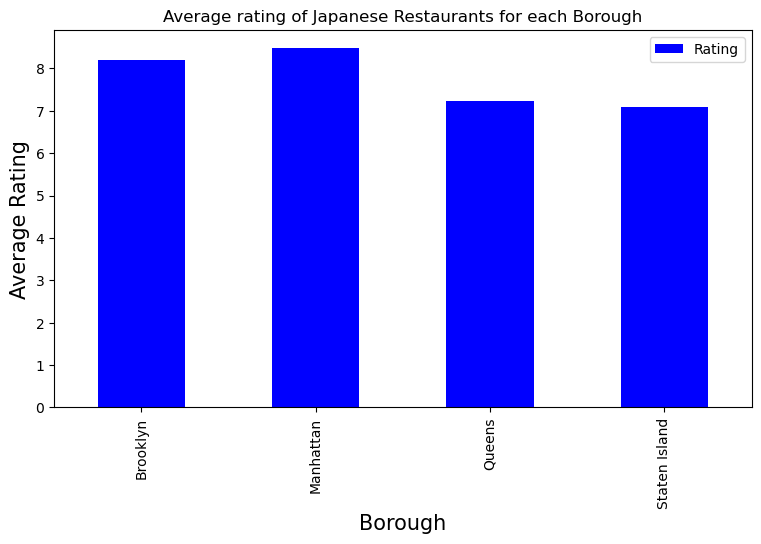

In [64]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [55]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.300000
1,Boerum Hill,8.800000
2,Brooklyn Heights,8.200000
4,Carroll Gardens,8.100000
6,Chelsea,8.700000
9,Cobble Hill,9.000000
10,Downtown,8.900000
11,East Village,9.250000
12,Flatiron,8.720000
13,Fort Hamilton,8.100000


In [56]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.300000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.800000
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.200000
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.100000
4,Manhattan,Chelsea,40.744035,-74.003116,8.700000
5,Staten Island,Chelsea,40.594726,-74.189560,8.700000
6,Brooklyn,Cobble Hill,40.687920,-73.998561,9.000000
7,Brooklyn,Downtown,40.690844,-73.983463,8.900000
8,Manhattan,East Village,40.727847,-73.982226,9.250000
9,Manhattan,Flatiron,40.739673,-73.990947,8.720000


In [57]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [60]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

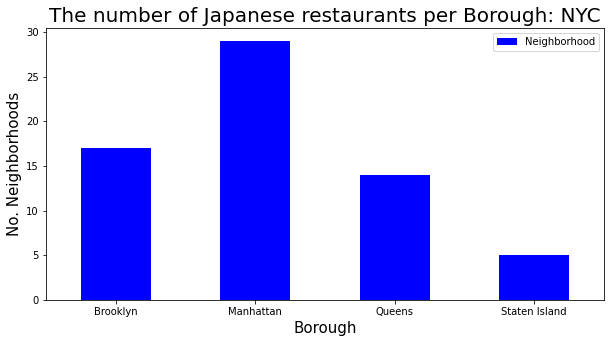

In [62]:
clr1 = "blue"
japanese_rest_stats_ny.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr1)
plt.title('The number of Japanese restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()